# Big Data Analytics - Pokemon API

## Introduction

The idea behind this project is to practice some of the techniques and topics learnt on the BDA subject. We had the freedom of choosing any topic that we desired, in this case the topic choosen is Pokemon Data Analysis. While it can be argued that this topic might not provide much value itself we can say for sure that it serves as an extremelly good playground for data analysis practice. This is due to the nature of the Pokemon game series in which there are a lot of stats and data surrounding all of the creatures and the world they live in. It can also be interesting to see how such a relevant comercial product might have evolved in order to adapt to recent times. The final reason that made this project a good option is how easily to access and use the PokéAPI proved to be, it also does not have any usage quotas as long as you make a fair use of it.


## Data Gathering

All of the data used for this project has ben obtained from the PokéAPI https://pokeapi.co/ which is an open and free api containing all sorts of data related to the pokemon videogame series. All of the data has been gathered using REST calls self contained on a script that takes care of the database population task. In this specific case, the database is a simple MongoDB setup hosted on a local machine since it was more than enough for this project. All of the data gathering has been made on python with the help of the requests and pymongo libraries. Some adaptations have been made from the original json structure in order to facilitate the data analysis. These include moving stats and types into basic variables, removing unused atributes and simplifying attributes with redundant data like species only keeping the name.

In order to see the docs of the api used you can go to: https://pokeapi.co/docs/v2

## Data Preprocessing

Some data processing has been made when gathering the data to have documents that are easier to analyze, here the code used to transform each json response from both the pokemon and pokemon-species endpoints responses can be seen:

```python
# Process Pokemon Collection
# Remove fields that wont be used for sure
del data['sprites']
del data['location_area_encounters']
# We only keep species name
data['species'] = data['species']['name']
# Types and stats are allways the same amount so change how they are stored to keep it simpler
del data['types']
del data['stats']
stats = {stat['stat']['name']: stat['base_stat'] for stat in res_data['stats']}

if len(res_data['types']) > 1:
    types = {
        'type1': res_data['types'][0]['type']['name'],
        'type2': res_data['types'][1]['type']['name']
    }
else:
    types = {
        'type1': res_data['types'][0]['type']['name'],
        'type2': None
    }      

# Merge all data
data.update(stats)
data.update(types)      
```
```python
# Process Pokemon-Species Collection
# Delete unwanted fields
        del data['egg_groups']
        del data['evolves_from_species']
        del data['flavor_text_entries']
        del data['form_descriptions']
        del data['genera']
        del data['growth_rate']
        del data['names']
        del data['pal_park_encounters']
        del data['pokedex_numbers']
        del data['varieties']
        del data['has_gender_differences']

        # Simplify some fields
        data['color'] = data['color']['name']        
        data['evolution_chain'] = data['evolution_chain']['url'].split('/')[-2]
        try:
            data['evolves_from'] = res_data['evolves_from_species']['name']
        except TypeError:
            data['evolves_from'] = None
        data['generation'] = data['generation']['name']
        try:
            data['habitat'] = data['habitat']['name']
        except TypeError:
            data['habitat'] = None
        data['gender_diff'] = res_data['has_gender_differences']
        data['shape'] = data['shape']['name']
```
There is missing data included on the type2 attribute, since many pokemon only have a single type assigned to them. However, this is expected and we just have to take into acount that there exist pokemon with a single type.

Some new fields can also be created during the analysis, it is also interesting to know which of the pokemon are legendary which is not included in the api data but can be obtained from other sources.

## Data Analysis
In this section a step by step exploratory data analysis will be performed following the code.

Firstly we make the necessary imports and write a small util to transform mongodb queries into dataframes.

In [97]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Mongo to dataframe utility
def query_df(collection, query={}, proj={}, no_id=True):
    cursor = collection.find(query, proj)
    df =  pd.DataFrame(list(cursor))
    if no_id:
        del df['_id']
    return df

# Function that displays a list dfs side by side
from IPython.display import display_html
def display_side_by_side(dfs):
    html_str=''
    for df in dfs:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

We then connect to the pokemon database.

In [98]:
# Connect to the db
db_name = 'pokebda'
client = pymongo.MongoClient('mongodb://localhost:27017/')
db = client[db_name]

After connecting to the database, go to the desired collection and make a simple query to get some basic information for all pokemon into a pandas dataframe.

In [99]:
# Load a projection of pokemon collection into a dataframe
pokemon = db['pokemon']

proj = {
    'id': 1,
    'name': 1,
    'species': 1,
    'height': 1,
    'weight': 1,
    'type1': 1,
    'type2': 1,
    'hp': 1,
    'attack': 1,
    'defense': 1,
    'special-attack': 1,
    'special-defense': 1,
    'speed': 1,
}
df = query_df(pokemon, {}, proj).set_index('id')
df.head()

,height,name,species,weight,hp,attack,defense,special-attack,special-defense,speed,type1,type2
id,,,,,,,,,,,,
1,7,bulbasaur,bulbasaur,69,45,49,49,65,65,45,grass,poison
2,10,ivysaur,ivysaur,130,60,62,63,80,80,60,grass,poison
3,20,venusaur,venusaur,1000,80,82,83,100,100,80,grass,poison
4,6,charmander,charmander,85,39,52,43,60,50,65,fire,None
5,11,charmeleon,charmeleon,190,58,64,58,80,65,80,fire,None


Look for missing data, missing data on type 2 is already expected.

In [100]:
df.isnull().sum()

height               0
name                 0
species              0
weight               0
hp                   0
attack               0
defense              0
special-attack       0
special-defense      0
speed                0
type1                0
type2              456
dtype: int64

Luckily no missing data is found on any of the choosen fields except the one already expected. Out of the 898 known existing pokemon 456 dont have two types, that is roughly a 50% of the cases. Lets do the same for the pokemon species collection.

In [101]:
# Load a projection pokemon-species collection into a dataframe
species = db['species']

proj = {
    'id': 1,
    'capture_rate': 1,
    'color': 1,
    'evolution_chain': 1,
    'forms_switchable': 1,
    'gender_rate': 1,
    'generation': 1,
    'habitat': 1,
    'is_baby': 1,
    'is_legendary': 1,
    'is_mythical': 1,
    'name': 1,
    'shape': 1,
    'evolves_from': 1,
    'gender_diff': 1
}
df2 = query_df(species, {}, proj).set_index('id')
df2.head()

,capture_rate,color,evolution_chain,forms_switchable,gender_rate,generation,habitat,is_baby,is_legendary,is_mythical,name,shape,evolves_from,gender_diff
id,,,,,,,,,,,,,,
1,45,green,1,False,1,generation-i,grassland,False,False,False,bulbasaur,quadruped,None,False
2,45,green,1,False,1,generation-i,grassland,False,False,False,ivysaur,quadruped,bulbasaur,False
3,45,green,1,True,1,generation-i,grassland,False,False,False,venusaur,quadruped,ivysaur,True
4,45,red,2,False,1,generation-i,mountain,False,False,False,charmander,upright,None,False
5,45,red,2,False,1,generation-i,mountain,False,False,False,charmeleon,upright,charmander,False


We also look for missing data here.

In [102]:
df2.isnull().sum()

capture_rate          0
color                 0
evolution_chain       0
forms_switchable      0
gender_rate           0
generation            0
habitat             512
is_baby               0
is_legendary          0
is_mythical           0
name                  0
shape                 0
evolves_from        468
gender_diff           0
dtype: int64

We see that the fields habitat and evolves_from present missing data on nearly the 50% of cases. For the habitat attribute it represents that such pokemon cannot be found in the wild and has to be obtained by different means such as evolution. In the case of evolves_from we can have two situations, the first one is a pokemon that is the first of an evolution chain, the second is when a pokemon does not belong to an evolution chain. Note that even when it does not have an evolution chain id is still assigned to itself.

Now we can start analyzing some of the gathered data, a good starting point can be to look at the pokemon stats. Any pokemon has a list of six different stats, these stats have a base value which is fixed for each of them and influences their strenghts and weaknessess. This is the list of existing stats:
- **HP:** Stands for hit points, determines how much damage it can recieve before becoming debilitated.
- **Attack:** Determines how much damage it can do, it is computed with the enemy's defense.
- **Defense:** Determines how good is resisting normal attacks.
- **Special Attack:** Determines how much special damage it can do, it is computed with the enemy's special defense.
- **Special Defense:** Determines how good is resisting special attacks.
- **Speed:** Is an indicator of how fast it is and helps calculating who attacks first.

Lets make histograms for each of the stats that exist for any pokemon ever created. 

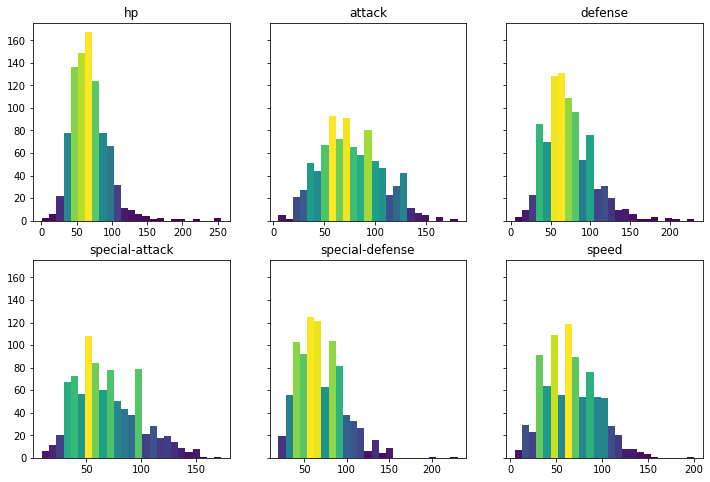

In [103]:
n_bins = 25
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(12,8))

stats = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']
for ax, st in zip(axs.reshape(-1), stats):
    ax.set_title(st)
    N, bins, patches = ax.hist(df[st], bins=n_bins)
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

We can see that all of the stats somewhat resemble a normal distribution with its mean arround 55, however some pretty big outliers can be seen on all of the plots. It can also be seen that standard deviation is much lower on the hp department and bigger on Attack Special Attack and Speed. Since we know that there are some outliers it can be interesting to see which are these specific cases for all categories, lets have a look by findig the top and bottom 5 for all stats.

In [104]:
stats = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']
dfs = []
for stat in stats:
   dfs.append(df.nlargest(5, stat)[['name', stat]])
display_side_by_side(dfs)
dfs = []
for stat in stats:
   dfs.append(df.nsmallest(5, stat)[['name', stat]])
display_side_by_side(dfs)

,name,hp
id,,
242,blissey,255
113,chansey,250
799,guzzlord,223
895,regidrago,200
202,wobbuffet,190
,name,attack
id,,
798,kartana,181
409,rampardos,165


,name,hp
id,,
292,shedinja,1
50,diglett,10
129,magikarp,20
172,pichu,20
213,shuckle,20
,name,attack
id,,
113,chansey,5
440,happiny,5


By looking at all of these stats we can see various names that are repeated on multiple categories, some of the most noticeable ones in terms of multiple categoriesare Shuckle, Blissey, Chansey and magikarp. Lets have a brief look at all of them.

**Shuckle** is the best on defense and special defense with a value of 230, it also has the worst special attack and speeds. His attack value is also the 4th worst. With all of this we can see that this is an extremelly deffensive creature with virtually no attack capabilities.
<div>
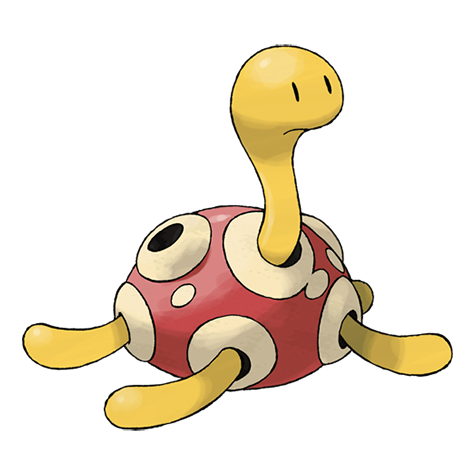
</div>

**Chansey & Blissey** are both pokemon from the same evolution line, which means that chansey evolves into Blissey into certain conditions which can help explain why they have very similar stat distributions. They are also very defensive pokemon but they strengths differ from the previous case. In this case their deffensive strategy is based on having the biggest amount of Hit Points on the entire game, however we can see that they also have an extremelly low phisical defense which makes them vulnerable to this type of attack. Their special defense values are 105 and 135 which in combination with their high HP makes them excellent against this type of damage.
<div>
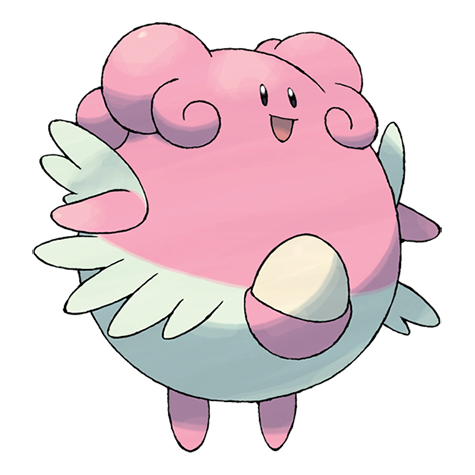
</div>
<div>
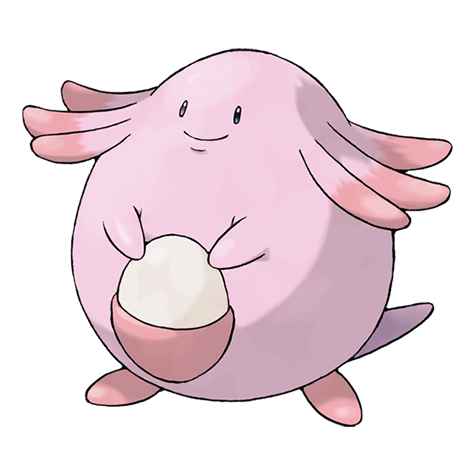
</div>

**Magikarp** is known to be one of the most useless creatures out of the 898 that do exist. This can be easily observed on the extracted data where it consistently appears on the top 5 worst for four different categories (hp, attack, special-attack, special-defense). This was expected since this innofensive fish looking pokemon was created with the intention of making it practically useless, however what makes it interesting is that it evolves into a very strong creature called Gyarados.
<div>
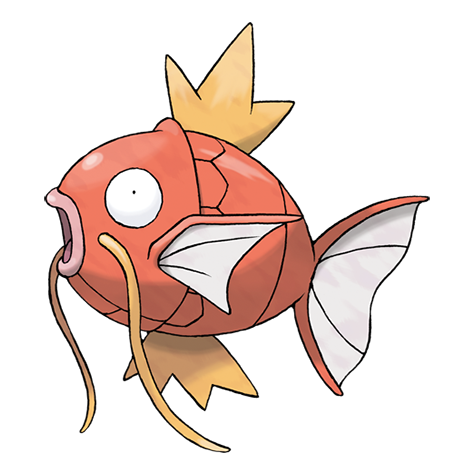
</div>

We now create a new attribute to evaluate total power to somewhat represent the combined amount of stats of each pokemon, however it is important to note that this does not directly correlate to a pokemon strength since it depends on the matchup and specialized stats can be situationally better in a lot of cases. We define this new attribute as power and compute it by summing the 6 base stats. We also join it with some the species data to have access to more information, in this case we look if they are mythic or legendary which are special categories of pokemon that are expected to be specially strong.

In [105]:
# Compute power attribute
df['power'] = df['hp'] + df['attack'] + df['defense'] + df['special-attack'] + df['special-defense'] + df['speed']

# Join by index (id) without overlapping attributes
df3 = df.join(df2.drop('name', axis=1))

# See top 10 and bottom 10 in terms of power
top_power = df3.nlargest(10, 'power')[['name', 'power', 'is_legendary', 'is_mythical']]
bottom_power = df3.nsmallest(10, 'power')[['name', 'power', 'is_legendary', 'is_mythical']]
display_side_by_side([top_power, bottom_power])

,name,power,is_legendary,is_mythical
id,,,,
493,arceus,720,False,True
890,eternatus,690,True,False
150,mewtwo,680,True,False
249,lugia,680,True,False
250,ho-oh,680,True,False
384,rayquaza,680,True,False
483,dialga,680,True,False
484,palkia,680,True,False
487,giratina-altered,680,True,False


There are various things that can be commented about the obtained results, the first one is that all of the most "powerful" pokemon are legendary, except from arceus which is mythical. Legendary and mythical creatures are expected to be the strongest, the main differentiation betwen these two categories is that mythical pokemon are expected to be even more rare than legendary ones but that is not related to having more power. The gathered power ladder matches the fact that legendary and mythiccal pokemon are among the strongest ocupying all of the top positions. In the case of the weakest none of them belongs to any of the two categories. Now lets proceed to looking at both the strongest and weakest pokemons that exist (Following our simplified criteria of raw stats).

In [106]:
basic_attr = ['shape', 'color', 'habitat', 'type1', 'type2', 'generation', 'type1', 'type2']
wishiwashi = df3.loc[df3['name'] == 'wishiwashi-solo']
arceus = df3.loc[df3['name'] == 'arceus']
display(wishiwashi[basic_attr])
display(arceus[basic_attr])

,shape,color,habitat,type1,type2,generation,type1,type2
id,,,,,,,,
746,fish,blue,None,water,None,generation-vii,water,None


,shape,color,habitat,type1,type2,generation,type1,type2
id,,,,,,,,
493,quadruped,white,None,normal,None,generation-iv,normal,None


**Wishiwashi Solo** is the weakest among all pokemon, as we can see it is a blue fish shaped pokemon that can be found on water. It was introduced on generation VII. This pokemon resembles a real sardine and has two form as it can be seen at the picture, when on its solo form it is the weakest of pokemons since it needs to group with its equals to be strong. 
<div>
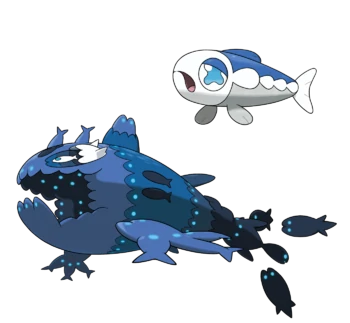
</div>

**Arceus** is a white quadruped that was introduced on generation IV, we can see that it has no habitat. This is because it is a mythic pokemon and cannot be found on the wild. The explanation on why it is the strongest pokemon its very starightforward. It is because it is considered the "god" and creator of the entire pokemon world itself, it is known as the pokemon god.
<div>
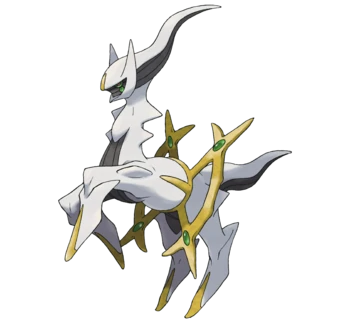
</div>

We can also see if there is any sort of correlation between stats, a good way to do so is by using a correlation matrix.

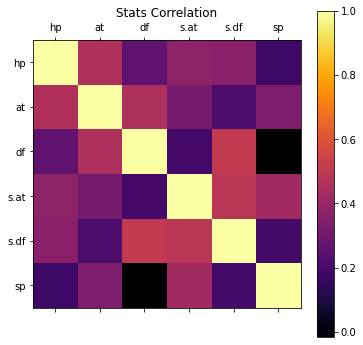

In [107]:
stats = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']

f, ax = plt.subplots(1, 1, figsize=(6,6))
stat_df = df[stats]
stat_df.columns = ['hp', 'at', 'df', 's.at', 's.df', 'sp']
cax = ax.matshow(stat_df.corr(), interpolation='nearest', cmap=plt.cm.inferno)
f.colorbar(cax)
ax.title.set_text('Stats Correlation')
ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(6))
ax.set_xticklabels(stat_df.columns)
ax.set_yticklabels(stat_df.columns);

We can see that the correlation between speed and defense is non existent. It is also interesting to see that attack and defense are somewhat correlating, this is because there are pokemon specialized in this type of combat which have two values for both of them. There also a similar correlation between special defense and special attack, also coming from creatures specialized on this type of combat. The highest correlation is the one of special defense and defense, probably due to all of the defensive pokemon having both of them.

It can also be interesting to see how some qualitative attributes are distributed among all pokemon, for example their shape color ,habitat or type.

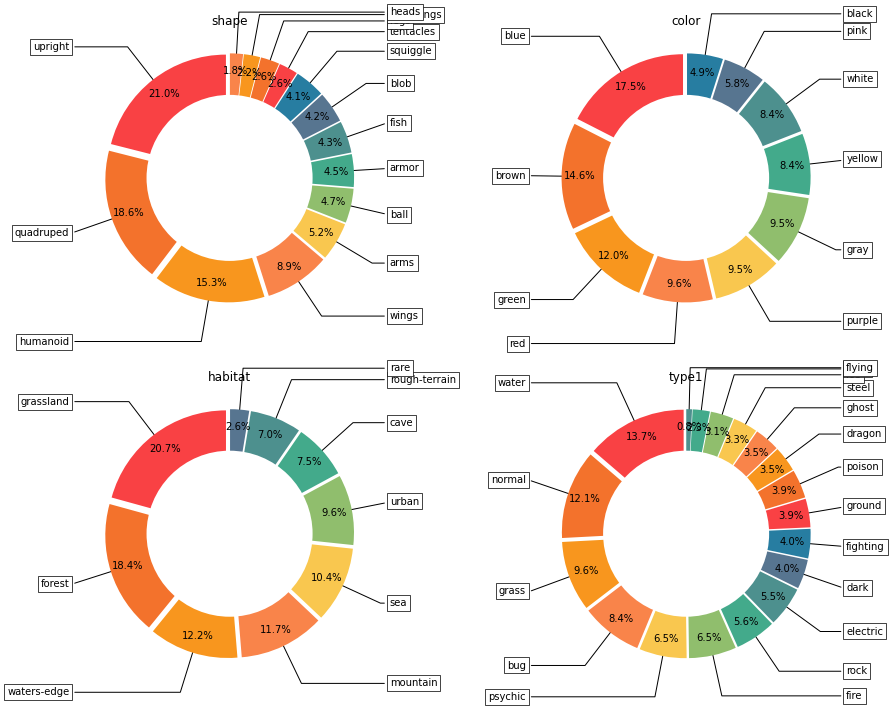

In [160]:
attrs = ['shape', 'color', 'habitat', 'type1']
colors = ["#f94144","#f3722c","#f8961e","#f9844a","#f9c74f","#90be6d","#43aa8b","#4d908e","#577590","#277da1"]

fig, axs = plt.subplots(2, 2, sharey=True, figsize=(15,12))
for ax, st in zip(axs.reshape(-1), attrs):
    
    vc = df3[st].value_counts()
    labels = vc.index.tolist()
    explode = [0.05] * len(labels) 
    circle = plt.Circle((0,0),0.70,fc='white')
    
    wedges, texts, _ = ax.pie(vc, startangle=90, autopct='%1.1f%%', pctdistance=0.85, explode=explode, colors=colors)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    
    ax.add_artist(circle)
    ax.set_title(st)

### Cronological analysis
In this subsection we will try to see how the series has evolved during all of its diferent releases and generations. Lets begin by seeing how many generations are there and grouping the data using that criteria.

In [108]:
print("List of different generations \n")
print(pd.unique(df2['generation']))

gens = df3.groupby('generation')

print("\n Pokemon per generation \n")
gens['name'].agg(['count'])

List of different generations 

['generation-i' 'generation-ii' 'generation-iii' 'generation-iv'
 'generation-v' 'generation-vi' 'generation-vii' 'generation-viii']

 Pokemon per generation 



,count
generation,
generation-i,151
generation-ii,100
generation-iii,135
generation-iv,107
generation-v,156
generation-vi,72
generation-vii,88
generation-viii,89


There are a total of 8 different generations, we can see that the number of new pokemon released on each of them has varied. It seems like on the last years a strategy of releasing less pokemon has been adopted. Lets see how many rare pokemon (Legendary & Mythic) where released on each generation.

In [109]:
n_legend = df2[df2['is_legendary'] == True].groupby('generation')['name'].agg(['count'])
n_mythic = df2[df2['is_mythical'] == True].groupby('generation')['name'].agg(['count'])
n_legend.columns = ['legendaries']
n_mythic.columns = ['mythics']
rares = n_legend.join(n_mythic)
rares['l+m'] = rares['legendaries'] + rares['mythics']
display(rares)

,legendaries,mythics,l+m
generation,,,
generation-i,4,1,5
generation-ii,5,1,6
generation-iii,8,2,10
generation-iv,9,5,14
generation-v,9,4,13
generation-vi,3,3,6
generation-vii,9,5,14
generation-viii,10,1,11


It looks like there are usually more legendaries than mythics, however we can see that on generation VI this is not the case and we have 3 for both categories. In terms of number of rare pokemon we can see that the number is allways quite low, it looks like from generation 3 the decision was to make more of then but for some reason on generation 6 this is not the case. It is also noticeable that since the last three generations have a smaller number of new pokemon the rare (l+m) percentage is higher. It can also be interesting to see if new pokemons are stronger than older ones.

In [114]:
gens['power'].agg(['min', 'max', 'mean', 'std'])

,min,max,mean,std
generation,,,,
generation-i,195,680,407.642384,99.875212
generation-ii,180,680,407.180000,112.456266
generation-iii,190,680,403.725926,115.570450
generation-iv,194,720,445.757009,117.478448
generation-v,255,680,425.756410,102.469720
generation-vi,200,680,429.583333,111.929398
generation-vii,175,680,449.409091,119.150985
generation-viii,180,690,432.359551,118.143330


It can be observed that mean pokemon power has indeed somewhat increased, despite that the strongest pokemon (Arceus) was released on generation 4 and the cap seems to be at 680 for all other generations, only surpased by 690 on the 8th one. The tendency of increasing mean pokemon power is reasonable and is probably done in order to keep people interested.